In [241]:
# standard imports
import os
import sys

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, JSON
from osgeo import gdal

# use GDAL specific exceptions
gdal.UseExceptions()

In [2]:
files = [
    './Vzorka_Asfalt/asfalt_geo.bsq',
    './Vzorka_Kroviny/kroviny_geo.bsq',
    './Vzorka_Polna cesta/polna_cesta_geo.bsq'
]

asfalt_geo.bsq (474, 103, 52)


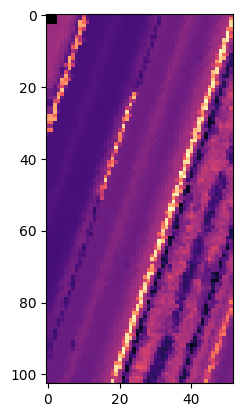

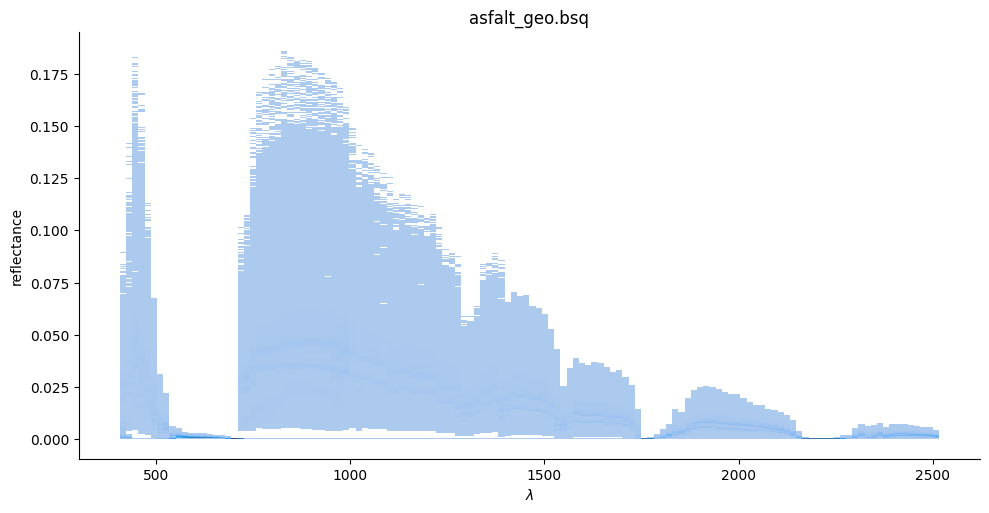

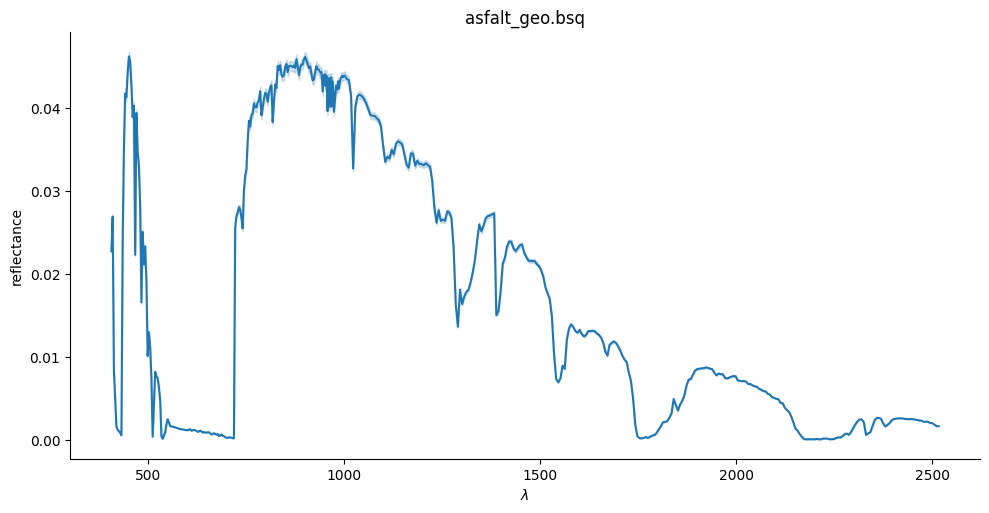

,reflectance,lambda
count,2.538744e+06,2.538744e+06
mean,1.800509e-02,1.329006e+03
std,2.018556e-02,6.248049e+02
min,0.000000e+00,4.067477e+02
25%,1.830155e-03,7.828967e+02
50%,1.010011e-02,1.227493e+03
75%,3.060337e-02,1.873135e+03
max,1.857653e-01,2.516052e+03


kroviny_geo.bsq (474, 131, 66)


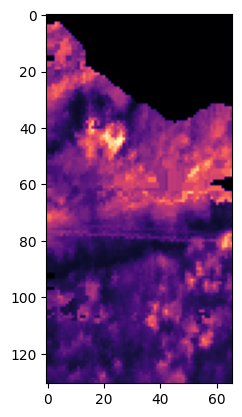

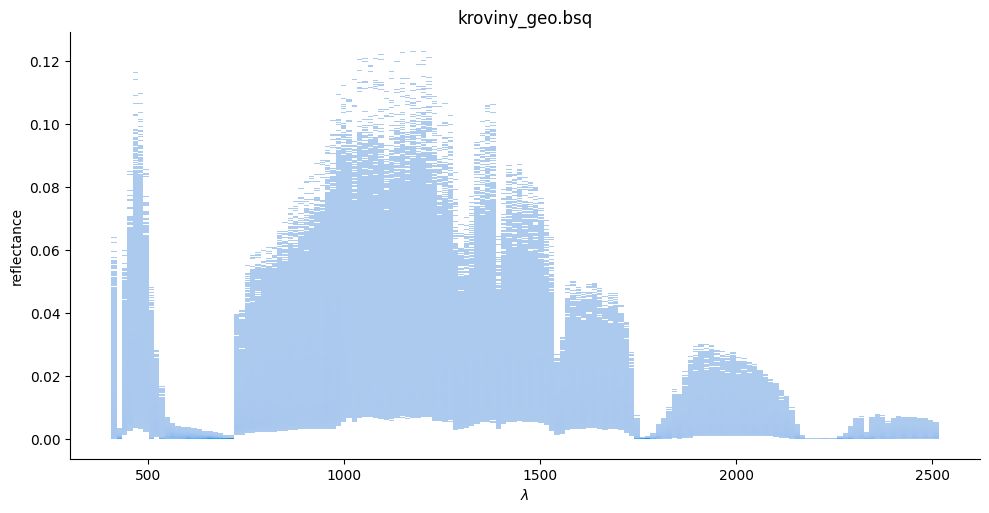

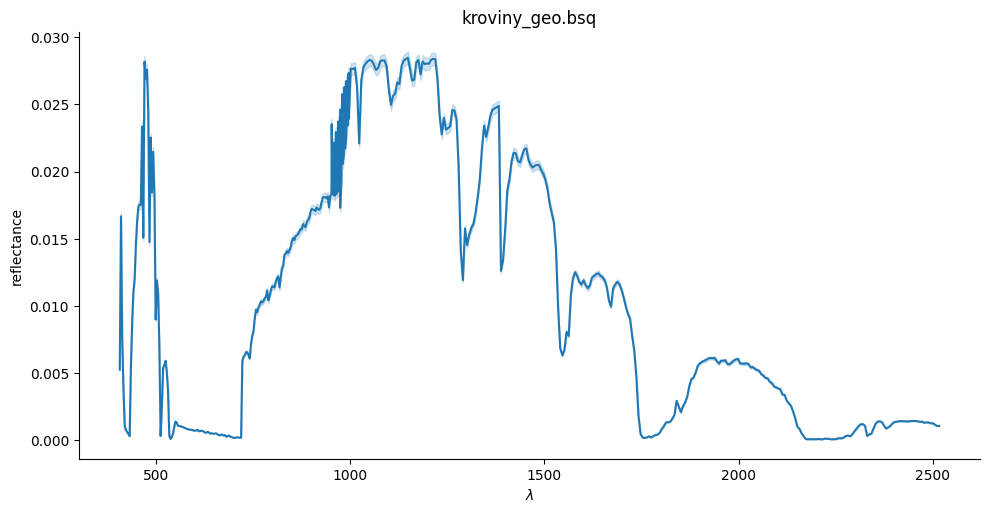

,reflectance,lambda
count,4.098204e+06,4.098204e+06
mean,1.049249e-02,1.329006e+03
std,1.454024e-02,6.248048e+02
min,0.000000e+00,4.067477e+02
25%,2.049668e-04,7.828967e+02
50%,3.882875e-03,1.227493e+03
75%,1.544546e-02,1.873135e+03
max,1.229816e-01,2.516052e+03


polna_cesta_geo.bsq (186, 79, 66)


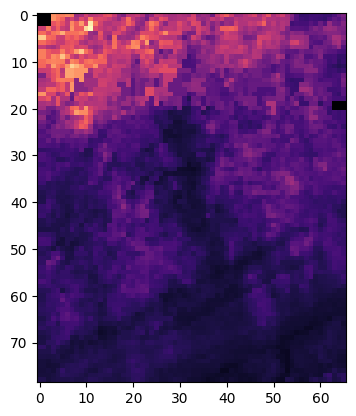

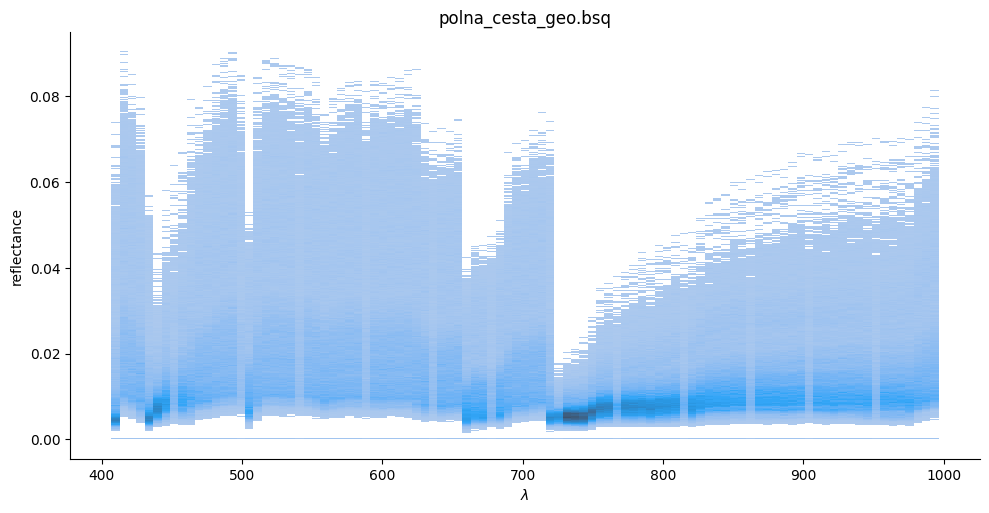

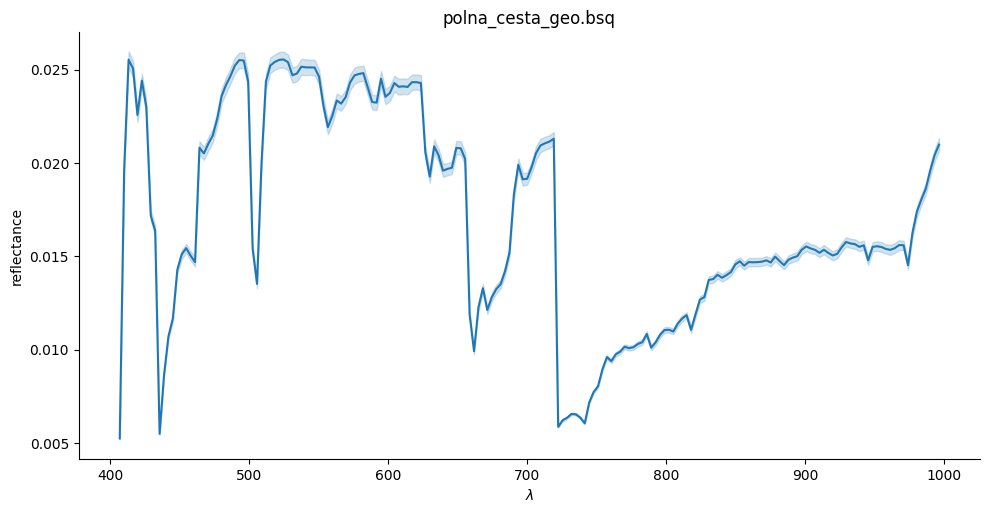

,reflectance,lambda
count,969804.000000,969804.000000
mean,0.017031,701.610352
std,0.012307,171.156815
min,0.000000,406.747681
25%,0.008714,553.382019
50%,0.013025,701.610260
75%,0.021191,849.838440
max,0.090481,996.472839


In [248]:
def plot_wavelengths_v3(df, title=None, filename=None, fileformat='pdf', **args):
    g = sns.relplot(df, x='lambda', y='reflectance', kind='line', **args)
    g.set(xticklabels=[])
    if title is not None:
        g.fig.suptitle(title)
        g.fig.subplots_adjust(top=0.8);
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()

    
    
for file in files:
    
    title = os.path.basename(file)
    
    display(HTML('<h2>%s</h2><hr/>' % title))
    
    ds = gdal.Open(file)

    data = ds.ReadAsArray()
    print(title, data.shape)
    plt.imshow(data[data.shape[0]//2,:,:], cmap='magma')
    plt.show()


    df_data = []
    for b in range(data.shape[0]):
        for x in range(data.shape[2]):
            for y in range(data.shape[1]):
                df_data.append(
                    {
                        'x': x,
                        'y': y,
                        'band': b+1,
                        'reflectance': data[b,y,x]
                    }
                )
    df = pd.DataFrame.from_dict(df_data)
    # display(df)

    md = ds.GetMetadata()
    df_wavelengths = pd.DataFrame.from_dict(
        {int(re.sub(r'Band_(\d+)', r'\1', k)) : np.float32(v) for k,v in md.items()},
        orient='index',
        columns=['lambda']
    )
    df_wavelengths.index = df_wavelengths.index.sort_values()
    df_wavelengths.index = df_wavelengths.index.rename('band')
    df_wavelengths = df_wavelengths.reset_index()
    # display(df_wavelengths)

    df = pd.merge(df, df_wavelengths, how='left', left_on='band', right_on='band')
    # display(df)

    ax = sns.displot(df, x='lambda', y='reflectance', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()

    ax = sns.relplot(df, x='lambda', y='reflectance', kind='line', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()

    display(df.drop(['x', 'y', 'band'], axis=1).describe())